Welcome to assignment 1.                                                       

We are using pathology images for our first assignment please download data from this link https://drive.google.com/drive/folders/10dUOzcPR-PQwfFYcHk5gsLjIjSorQ32Q?usp=sharing



# Task 1: Feature Generation (15%)
# Use and run the following code (a deep network) to generate features from a set of training images. For this assignment, you do not need to know how the deep network is working here to extract features.
# This code extracts the features of image T4.tif (in the T folder of dataset). Modify the code so that it iterates over all images of the dataset and extracts their features.
# Allocate 10% of the data for validation.

# Insert your code here for Task 1





In [62]:
import os
import numpy as np
import random
import torch
import torchvision.transforms as transforms
from torchvision.models import densenet121
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt

# Load pre-trained DenseNet model
model = densenet121(pretrained=True)

# Remove the classification layer (last fully connected layer)
model = torch.nn.Sequential(*list(model.children())[:-1])

# Add a global average pooling layer
model.add_module('global_avg_pool', torch.nn.AdaptiveAvgPool2d(1))

# Set the model to evaluation mode
model.eval()

# Define the image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset folder
imageNames = []
extractedFeatures = []

#shouldn't need to change the root directory if you pulled correctly
for root, _, files in os.walk('.\\train-20240206T024149Z-001\\train'):
    for file in files:
            imageNames.append(os.path.join(root, file))
            # Load an image
            image_path = os.path.join(root, file)

            # get_image_files(image_path)

            image = Image.open(image_path)

            # Preprocess the image
            input_tensor = preprocess(image)
            input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

            # Wrap the input tensor in a Variable
            input_var = Variable(input_batch)

            # Forward pass through the model
            features = model(input_var)

            # Extract the feature tensor
            feature_vector = features.squeeze().detach().numpy()

            # Now 'feature_vector' contains the feature from the last fully connected layer of DenseNet
            #print("Feature vector shape:", feature_vector.shape)
            # for feature in feature_vector:
            #     print(feature)
            extractedFeatures.append(feature_vector)

#check to see if all images were parsed through
print(len(extractedFeatures))

# Needed to convert to np array. was having issues with just normal list
extractedFeatures = np.array(extractedFeatures)

# Splitting the data
tenPercentLength = int(len(extractedFeatures) * 0.1)
randomIndices = np.random.choice(len(extractedFeatures), size=tenPercentLength, replace=False)

# Extract the elements corresponding to the random indices for test set
validationFeatures = extractedFeatures[randomIndices]
validationImageNames = [imageNames[i] for i in randomIndices]

# Extract the remaining elements for training set
trainFeatures = np.delete(extractedFeatures, randomIndices, axis=0)
trainImageNames = [imageNames[i] for i in range(len(imageNames)) if i not in randomIndices]

# I (Jared) needed this for KMeans (if anyone else needs this I (Jared) can explain how it works)
# Get the letter labels for validation and training sets
validationLabels = [label.split('\\')[-2][-1] for label in validationImageNames]
trainLabels = [label.split('\\')[-2][-1] for label in trainImageNames]

# Create a mapping between letter labels and numeric labels
unique_labels = np.unique(trainLabels)
label_mapping = {label: i for i, label in enumerate(unique_labels)}

# Convert letter labels to numeric labels
validationLabelsNum = [label_mapping[label] for label in validationLabels]
trainLabelsNum = [label_mapping[label] for label in trainLabels]

print('Test Set Length:', len(validationFeatures))
print('Train Set Length:', len(trainFeatures))

c:\Users\shahe\anaconda3\envs\tutorials\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shahe\anaconda3\envs\tutorials\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


780
Test Set Length: 78
Train Set Length: 702


# Task 2: High Bias Classification Method (5%)
# Choose a classification method and let is have a high bias.
# Train it on the generated features and discuss why it is underfitting.

# Insert your code here for Task 2




In [63]:
# Linear regression chosen as classification method
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

# Fit training data and model
model.fit(trainFeatures, trainLabelsNum)

# Run model on train and val sets
trainPredictions = model.predict(trainFeatures)
valPredictions = model.predict(validationFeatures)

# MSE on training and validation sets
trainMSE = mean_squared_error(trainLabelsNum, trainPredictions)
valMSE = mean_squared_error(validationLabelsNum, valPredictions)

print("Train MSE:", trainMSE)
print("Validation MSE:", valMSE)

print("The low MSE for the train set is expected but the high MSE for the validation set indicates that the data is far \nfrom the line of best fit. This shows that the data is underfitted given the high bias.")

Train MSE: 0.0005272344548479993
Validation MSE: 84.34489940797236
The low MSE for the train set is expected but the high MSE for the validation set indicates that the data is far 
from the line of best fit. This shows that the data is underfitted given the high bias.


# Task 3: High Variance Classification Method (5%)
# Use the chosen classification method and let it have a high variance.
# Train it on the generated features and discuss why it is overfitting.

# Insert your code here for Task 3




In [64]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Create polynomial features
polyFeatures = PolynomialFeatures(2)
trainFeaturesPoly = polyFeatures.fit_transform(trainFeatures)
validationFeaturesPoly = polyFeatures.transform(validationFeatures)

model = LinearRegression()

# Fit the model to the training data
model.fit(trainFeaturesPoly, trainLabelsNum)

# Run model on train and val sets
trainPredictionsHighV = model.predict(trainFeaturesPoly)
valPredictionsHighV = model.predict(validationFeaturesPoly)

# MSE on training and validation sets
trainMSEHighV = mean_squared_error(trainLabelsNum, trainPredictionsHighV)
valMSEHighV = mean_squared_error(validationLabelsNum, valPredictionsHighV)

print("Train MSE:", trainMSEHighV)
print("Validation MSE:", valMSEHighV)

print("The MSE for the validation set is much lower compared to task 2. This shows that the data point is \nvery close to the line of best fit indicating overfitting.")

Train MSE: 8.281784906483884e-10
Validation MSE: 5.638603364466794
The MSE for the validation set is much lower compared to task 2. This shows that the data point is 
very close to the line of best fit indicating overfitting.


# Task 4: Balanced Classification Method (15%)
# Use the chosen classification method and let it balance the bias and variance.
# Train it on the generated features, possibly adjusting parameters.
# Discuss insights into achieving balance.

# Insert your code here for Task 4




In [65]:
print("To balance the bias and variance in linear regression, a regularization method called Ridge (also known as L2) is used in this Task. \nIt reduces overfitting by dicsouraging large coefficients in the model.\n")
from sklearn.linear_model import Ridge

#Introduce an adjustable regularization parameter for Ridge
reg_parameter = 0.05

#Initialize Ridge
ridge_balanced = Ridge(reg_parameter)

#Fit the Ridge model to the Task 1 outputs
ridge_balanced.fit(trainFeatures, trainLabelsNum)

#Predict the validation set labels
validLabels_balanced = ridge_balanced.predict(validationFeatures)

#MSE for the training and validations sets
valid_MSE_balanced = mean_squared_error(validationLabelsNum, validLabels_balanced)
print("Validation MSE", valid_MSE_balanced)
print("The MSE value indicates a balanced fit as it lands between the underfitted Task 2 and overfitted Task 3. \nHigher parameter values reduce MSE, while lower values increase it.")


To balance the bias and variance in linear regression, a regularization method called Ridge (also known as L2) is used in this Task. 
It reduces overfitting by dicsouraging large coefficients in the model.

Validation MSE 22.291880471236045
The MSE value indicates a balanced fit as it lands between the underfitted Task 2 and overfitted Task 3. 
Higher parameter values reduce MSE, while lower values increase it.


# Task 5: K-Means Clustering (20%)
# Apply K-Means clustering on the generated features.
# Test with available labels and report accuracy.
# Experiment with automated K and compare with manually set 20 clusters.

# Insert your code here for Task 5




In [66]:
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

##### HELPER FUNCTIONS #####

# helper function to map the labels from the KMeans data to the training data
def map_labels(train_labels, cluster_labels, predict_labels):

    # Compute confusion matrix
    conf_matrix = confusion_matrix(train_labels, cluster_labels)

    # Apply the Hungarian algorithm to find the best matching
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)

    # Map KMeans labels to train labels based on the best matching
    label_mapping = {k: v for k, v in zip(col_ind, row_ind)}

    # Map prediction (KMean) labels to original labels
    prediction_mapped = [label_mapping[label] for label in predict_labels]

    return prediction_mapped

# helper function to auto select the value of K (clusters) using the elbow method
def autoK(features, max_clusters):
    wcss = []
    
    # iterate through K = 2, 3, ..., max_clusters + 1 and keep track of WCSS value for each
    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters = i, init='k-means++', random_state = 420)
        kmeans.fit(features)
        wcss.append(kmeans.inertia_)

    # Calculate the first derivative of the WCSS and use it to find the elbow point
    differences = np.diff(wcss)
    elbow_point = np.argmax(differences) + 1
        
    return elbow_point

##### MAIN CODE #####

# Apply KMeans clustering to data using K clusters = 20
kmeans_man = KMeans(n_clusters = 20, random_state = 420)
kmeans_man.fit(trainFeatures)

# predict test data and map the predicted clusters numbers to the corresponding trained cluster numbers
prediction_man = kmeans_man.predict(validationFeatures)
prediction_man_mapped = map_labels(trainLabelsNum, kmeans_man.labels_, prediction_man)

# check accuracy
accuracy = accuracy_score(validationLabelsNum, prediction_man_mapped)
print("Accuracy K (20) = ", accuracy)

# set K (auto)
K = autoK(trainFeatures, max_clusters = 40)
print("Automated K Value = ", K)

# Apply KMeans clustering to data using K clusters = auto
kmeans_auto = KMeans(n_clusters = K, random_state = 420)
kmeans_auto.fit(trainFeatures)

# predict test data and map the predicted clusters numbers to the corresponding trained cluster numbers
prediction_auto = kmeans_auto.predict(validationFeatures)
prediction_auto_mapped = map_labels(trainLabelsNum, kmeans_auto.labels_, prediction_auto)

# check accuracy
accuracy = accuracy_score(validationLabelsNum, prediction_auto_mapped)
print("Accuracy K (Auto) = ", accuracy)

#plot results
#fig = plt.figure(2, figsize = (11,4))

# K = 20
#ax = fig.add_subplot(121, projection='3d')
#ax.scatter(trainFeatures[:,0],trainFeatures[:,1], trainFeatures[:,2], c=labels_man, cmap='Set2')
#plt.title('KMeans using sklearn, K = 20')

# auto K
#ax = fig.add_subplot(122,projection='3d')
#ax.scatter(trainFeatures[:,0],trainFeatures[:,1], trainFeatures[:,2], c=labels_auto, cmap='Set2')
#plt.title('KMeans using sklearn, K = auto')
#plt.show()


c:\Users\shahe\anaconda3\envs\tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy K (20) =  0.6794871794871795


c:\Users\shahe\anaconda3\envs\tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\shahe\anaconda3\envs\tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\shahe\anaconda3\envs\tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\shahe\anaconda3\envs\tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_

Automated K Value =  35


c:\Users\shahe\anaconda3\envs\tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy K (Auto) =  0.6410256410256411


# Task 6: Additional Clustering Algorithm (10%)
# Choose another clustering algorithm and apply it on the features.
# Test accuracy with available labels.

# Insert your code here for Task 6




In [67]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier


#Define the clustering model using Decision Tree
dec_tree_class = DecisionTreeClassifier(max_depth=20, random_state=56)

#Fit the Task 1 output to the clustering model
dec_tree_class.fit(trainFeatures, trainLabelsNum)

#Produce clusters (labels) for the validation set by prediction
validation_clusters = dec_tree_class.predict(validationFeatures)

#Test accuracy using available labels
accuracy = accuracy_score(validationLabelsNum, validation_clusters)
print("Accuracy:", accuracy)
print("High accuracy score is indicative of good model performance. To achieve this, the max depth of the decision tree had to be experimentally gradually increased to 20.")

Accuracy: 0.782051282051282
High accuracy score is indicative of good model performance. To achieve this, the max depth of the decision tree had to be experimentally gradually increased to 20.


# Task 7: PCA for Classification Improvement (20%)
# Apply PCA on the features and then feed them to the best classification method in the above tasks.
# Assess if PCA improves outcomes and discuss the results.

# Insert your code here for Task 7





Applying dimensionality reduction using PCA:
Original dimensions: (702, 1024)
Reduced dimensions using sklearn for trial: (702, 50)
Reduced dimensions of training data using sklearn for final implementation: (702, 9)
Reduced dimensions of validation data using sklearn for final implementation: (78, 9)
By applying PCA for dimensionality reduction, we should have less noise in the data for other clustering and classification methods

Applying Ridge Regression to the projected data:
Validation MSE 16.098580051263127

Applying K-Means to the projected data:
Accuracy K (20) =  0.6794871794871795


c:\Users\shahe\anaconda3\envs\tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\shahe\anaconda3\envs\tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\shahe\anaconda3\envs\tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\shahe\anaconda3\envs\tutorials\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_

Automated K Value =  35
Accuracy K (Auto) =  0.5128205128205128

Applying Decision Trees to the projected data:
Accuracy: 0.7564102564102564


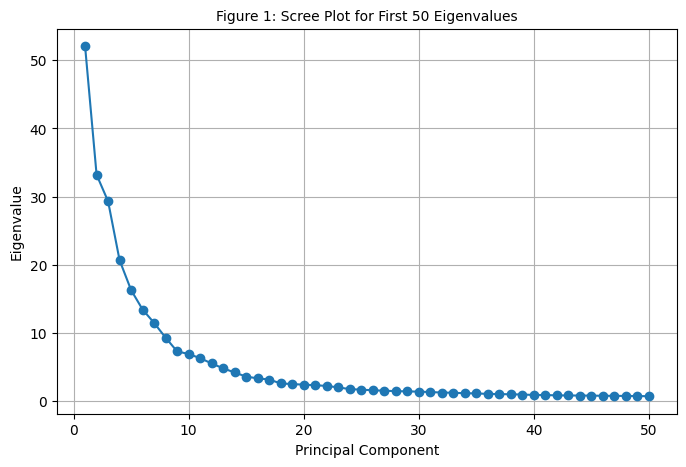

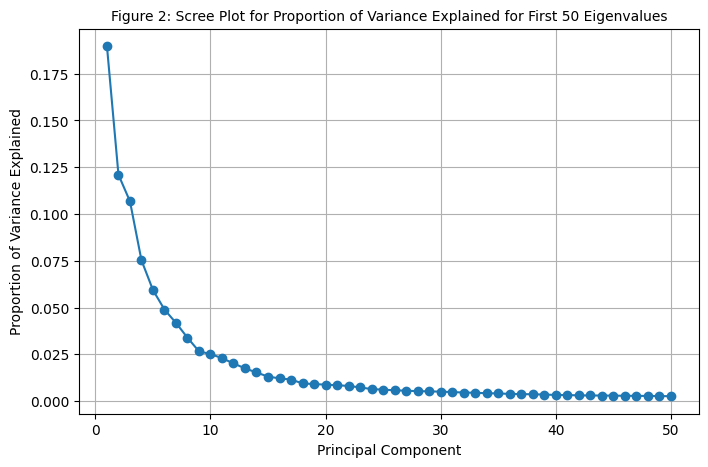

In [68]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import Ridge

from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier

# using sklearn's implementation of PCA
from sklearn.decomposition import PCA

# Applying PCA ------------------------------------------------------------------------------------------------------------

print('\nApplying dimensionality reduction using PCA:')

#check current number of features (dimensions) for each image
print('Original dimensions:', trainFeatures.shape)

# project from 1024 dimensions to 50 using PCA to start
# 50 is a large number of dimensions, but this will allow us to make a scree plot and select an ideal number of PCs
k_trial = 50

# find PCs based on training data and project them onto the first 100 PCs
pca_trial = PCA(k_trial)  
projected_trial = pca_trial.fit_transform(trainFeatures)
print('Reduced dimensions using sklearn for trial:', projected_trial.shape)

# get the eigenvalues of the PCA trial 
# find the ratio of each eigenvalue to the sum of all other eigenvalues
eigenvalues = pca_trial.explained_variance_
eigenvalues_ratios = eigenvalues / np.sum(eigenvalues)

# create a scree plot
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues, marker = 'o')
plt.xlabel('Principal Component', size = 10)
plt.ylabel('Eigenvalue', size = 10)
plt.title('Figure 1: Scree Plot for First 50 Eigenvalues', size = 10)
plt.grid(True)

# create a scree plot using ratios of eigenvalues
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(eigenvalues_ratios)+1), eigenvalues_ratios, marker='o')
plt.xlabel('Principal Component', size = 10)
plt.ylabel('Proportion of Variance Explained', size = 10)
plt.title('Figure 2: Scree Plot for Proportion of Variance Explained for First 50 Eigenvalues', size = 10)
plt.grid(True)

# based on these plots, the last significant drop occurs for PC 9
# re-run PCA to reduce the dimensionality to 9
# project the training and validation data on the 9 largest PCs

k_final = 9

pca_final = PCA(k_final)  
projected_training_data = pca_final.fit_transform(trainFeatures)
projected_validation_data = pca_final.transform(validationFeatures)
print('Reduced dimensions of training data using sklearn for final implementation:', projected_training_data.shape)
print('Reduced dimensions of validation data using sklearn for final implementation:', projected_validation_data.shape)

print('By applying PCA for dimensionality reduction, we should have less noise in the data for other clustering and classification methods')

# Applying Ridge Regression ------------------------------------------------------------------------------------------

print('\nApplying Ridge Regression to the projected data:')

#Introduce an adjustable regularization parameter for Ridge
reg_parameter = 0.05

#Initialize Ridge
ridge_balanced = Ridge(reg_parameter)

#Fit the Ridge model to the Task 1 outputs
ridge_balanced.fit(projected_training_data, trainLabelsNum)

#Predict the validation set labels
validLabels_balanced = ridge_balanced.predict(projected_validation_data)

#MSE for the training and validations sets
valid_MSE_balanced = mean_squared_error(validationLabelsNum, validLabels_balanced)
print("Validation MSE", valid_MSE_balanced)

# Applying K-Means Clustering ------------------------------------------------------------------------------------------

print('\nApplying K-Means to the projected data:')

# Apply KMeans clustering to data using K clusters = 20
kmeans_man_pca = KMeans(n_clusters = 20, random_state = 420)
kmeans_man_pca.fit(projected_training_data)

# predict test data and map the predicted clusters numbers to the corresponding trained cluster numbers
prediction_man_pca = kmeans_man_pca.predict(projected_validation_data)
prediction_man_mapped_pca = map_labels(trainLabelsNum, kmeans_man.labels_, prediction_man)

# check accuracy
accuracy = accuracy_score(validationLabelsNum, prediction_man_mapped)
print("Accuracy K (20) = ", accuracy)

# set K (auto)
K = autoK(projected_training_data, max_clusters = 40)
print("Automated K Value = ", K)

# Apply KMeans clustering to data using K clusters = auto
kmeans_auto = KMeans(n_clusters = K, random_state = 420)
kmeans_auto.fit(projected_training_data)

# predict test data and map the predicted clusters numbers to the corresponding trained cluster numbers
prediction_auto = kmeans_auto.predict(projected_validation_data)
prediction_auto_mapped = map_labels(trainLabelsNum, kmeans_auto.labels_, prediction_auto)

# check accuracy
accuracy = accuracy_score(validationLabelsNum, prediction_auto_mapped)
print("Accuracy K (Auto) = ", accuracy)

# Applying Decision Trees --------------------------------------------------------------------------------------------

print('\nApplying Decision Trees to the projected data:')

#Define the clustering model using Decision Tree
dec_tree_class = DecisionTreeClassifier(max_depth=20, random_state=56)

#Fit the Task 1 output to the clustering model
dec_tree_class.fit(projected_training_data, trainLabelsNum)

#Produce clusters (labels) for the validation set by prediction
validation_clusters = dec_tree_class.predict(projected_validation_data)

#Test accuracy using available labels
accuracy = accuracy_score(validationLabelsNum, validation_clusters)
print("Accuracy:", accuracy)

# Task 8: Visualization and Analysis (10%)
# Plot the features in a lower dimension using dimentinality reduction techniques.
# Analyze the visual representation, identifying patterns or insights.

# Insert your code here for Task 8